In [67]:
import numpy as np
import pandas as pd

In [68]:
import warnings
warnings.filterwarnings('ignore')

In [80]:
#데이터 로드
stock_df=pd.read_csv('/NH_CONTEST_NW_FC_STK_IEM_IFO.csv',encoding='cp949')
stock_info=pd.read_csv('/NH_CONTEST_STK_DT_QUT.csv',encoding='cp949')
trade_info=pd.read_csv('/NH_CONTEST_NHDATA_STK_DD_IFO.csv',encoding='cp949')
cust=pd.read_csv('/NH_CONTEST_NHDATA_CUS_TP_IFO.csv',encoding='cp949')

In [81]:
#종목명 공백 제거
stock_info['tck_iem_cd']=stock_info['tck_iem_cd'].str.rstrip()
trade_info['tck_iem_cd']=trade_info['tck_iem_cd'].str.rstrip()
cust['tck_iem_cd']=cust['tck_iem_cd'].str.rstrip()

In [82]:
#주식 종목 & 시가총액이 0이 아닌 종목 추출
stock_df=stock_df[(stock_df['stk_etf_dit_cd']=='주식')&(stock_df['mkt_pr_tot_amt']!=0)]
stock_lst1=list(stock_df['tck_iem_cd'].unique())

In [83]:
#기준일자 날짜형으로 변환
from datetime import datetime
stock_info['bse_dt']=pd.to_datetime(stock_info['bse_dt'],format='%Y%m%d')
trade_info['bse_dt']=pd.to_datetime(trade_info['bse_dt'],format='%Y%m%d')

In [84]:
#이상치 제거 (수익률 200 이상)
trade_info=trade_info[trade_info['tco_avg_pft_rt']<=200]

In [85]:
#종목일자별시세 데이터 - 3개월동안 정보가 모두 존재하는 주식 종목만 추출
cnt=stock_info.groupby('tck_iem_cd')['bse_dt'].count()
cnt=cnt.reset_index()
cnt=cnt[cnt['bse_dt']==63]
stock_lst2=list(cnt['tck_iem_cd'].unique())

In [86]:
#주식일별정보 데이터 - 3개월동안 정보가 모두 존재하는 주식 종목만 추출
cnt=trade_info.groupby('tck_iem_cd')['bse_dt'].count()
cnt=cnt.reset_index()
cnt=cnt[cnt['bse_dt']==64]
stock_lst3=list(cnt['tck_iem_cd'].unique())

In [87]:
#세 개의 데이터셋에서 중복되는 종목을 분석 대상으로 선정
stock_lst=list(set(stock_lst1)&set(stock_lst2)&set(stock_lst3))

In [88]:
stock_df=stock_df[stock_df['tck_iem_cd'].isin(stock_lst)]
stock_info=stock_info[stock_info['tck_iem_cd'].isin(stock_lst)]
stock_info.sort_values(['tck_iem_cd','bse_dt'],inplace=True)
trade_info=trade_info[trade_info['tck_iem_cd'].isin(stock_lst)]
trade_info.sort_values(['tck_iem_cd','bse_dt'],inplace=True)
#NH데이터는 정보가 24/08/27 데이터가 있어서 제거해 분석 기간 통일 
trade_info=trade_info[trade_info['bse_dt']!='2024-08-27T00:00:00.000000000']

In [89]:
#가격 변동성을 확인하기 위한 일일변동폭 파생변수 생성
stock_info['daily_mov']=(stock_info['iem_hi_pr']-stock_info['iem_low_pr'])

In [90]:
#분석에 사용할 변수 선택
plot_df=stock_df[['tck_iem_cd','ser_cfc_nm']]
stock_df=stock_df[['tck_iem_cd','ltg_tot_stk_qty','mkt_pr_tot_amt']]
stock_info.drop('sby_bse_xcg_rt',axis=1,inplace=True)
trade_info.drop(['tco_avg_hld_te_dd_cnt','dist_hnk_pct10_nmv','dist_hnk_pct30_nmv','dist_hnk_pct50_nmv','dist_hnk_pct70_nmv','dist_hnk_pct90_nmv','bse_end_pr'],axis=1,inplace=True)

In [91]:
#EDA
#상관관계 plot 
corr_df=pd.merge(stock_info,trade_info,on=['bse_dt','tck_iem_cd'],how='inner')
corr_df.drop('bse_dt',axis=1,inplace=True)
corr_df=corr_df.groupby('tck_iem_cd').mean().reset_index()
corr_df=pd.merge(corr_df,stock_df,on='tck_iem_cd',how='inner')

Text(0.5, 1.0, 'Correlation Plot')

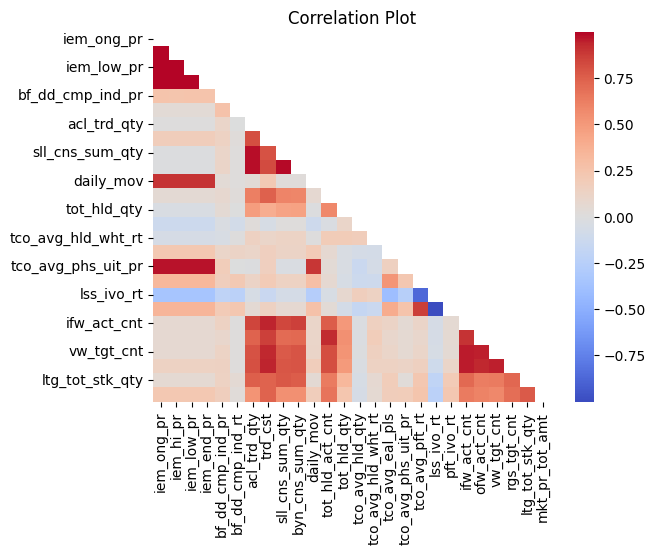

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_df.drop('tck_iem_cd',axis=1,inplace=True)
corr_mat=corr_df.corr()
mask = np.triu(np.ones_like(corr_mat, dtype=bool))
sns.heatmap(corr_mat, annot=False, mask=mask, cmap='coolwarm',fmt='.2f')
plt.title('Correlation Plot')